# Imports

In [3]:
!pip install autogluon
!pip install catboost
!pip install pandas
!pip install numpy
!pip install matplotlib


In [4]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import os
import matplotlib.pyplot as plt
from typing import List


# Load datasets

In [5]:

folder = '../data/'
A = folder + 'A/'
B = folder + 'B/'
C = folder + 'C/'

XTRO = 'X_train_observed.parquet'
XTRE = 'X_train_estimated.parquet'
XTEE = 'X_test_estimated.parquet'
Y = 'train_targets.parquet'

relative_filepaths = {"A": A, "B": B, "C": C}

def get_df_from_parquet(filepath: str) -> pd.DataFrame:
    """
    Returns DataFrame when given filepath to .parquet file
    """
    return pd.read_parquet(filepath)

def merge_x(xo_path, xe_path):
    xo = get_df_from_parquet(xo_path)
    xe = get_df_from_parquet(xe_path)
    xo['estimated'] = 0
    xe['estimated'] = 1
    xo['estimation_calc_forecast_difference'] = 0
    time_diff = []
    for i in range(len(xe)):
        time_diff.append(abs((xe['date_forecast'].iloc[i] - xe['date_calc'].iloc[i]).seconds))
    xe['estimation_calc_forecast_difference'] = time_diff

    if 'date_calc' in xe.columns:
         xe.drop(columns=['date_calc'], inplace=True)
    x_train = pd.concat([xo, xe])
    return x_train

def append_x_y(x_list, y_list, merge, path):
    if merge:
        x_list.append(merge_x(path+XTRO, path+XTRE))
    else: 
        x_list.append(get_df_from_parquet(path+XTRO)) #appending observed X train
        x_list.append(get_df_from_parquet(path+XTRE)) #appendeing estimated X train
    y_list.append(get_df_from_parquet(path+Y)) # appending target Y

def get_training_data(location: str or list = None, merge: bool = True) -> List[List[pd.DataFrame]]:
    """
    Returns tuple with merged x_train data for given location(s) in a list and corresponding list of targets

    OR if none given, returns all locations x_train_merged per location 
    
    **in order A, B, C <----------NB!** or order given. 

    RETURNS: List[List[x_train: pd.DataFrame], List[y_target: pd.DataFrame]]

    NOTE: If merge = False the list returned is [x_train_observed_A, x_train_estimated_A,...]
    """
    ### dealing with current working directory for relative paths ###
    # cwd_old = os.getcwd()
    # file_loc = os.path.abspath(__file__)
    # cwd_new = os.path.dirname(file_loc)
    # os.chdir(cwd_new)
    
    x_train_list = []
    y_target_list = []
    
    if location == None: 
        for i in relative_filepaths:
            path = relative_filepaths[i]
            append_x_y(x_train_list, y_target_list, merge, path)
    
    elif type(location) == str:
        try:
            path = relative_filepaths[location] 
            append_x_y(x_train_list, y_target_list, merge, path)
        except Exception as e:
            print(f'\nProbaly no matching location for passed string: {location}')
            raise Exception(e)
        
    
    elif type(location) == list:
        for loc in location: 
            try: 
                path = relative_filepaths[loc]
                append_x_y(x_train_list, y_target_list, merge, path)
            except Exception as e:
                print(f'\nProbaly no matching location for passed strings:{location}')
                raise Exception(e)
    
    # os.chdir(cwd_old)
    ### returning working directory ###
    return [x_train_list, y_target_list]

def get_test_data(location: str or list = None) -> List[pd.DataFrame]:
    """
    Returns list with x_test data for given location(s) in a list

    OR if none given, returns all locations x_testper location 
    
    **in order A, B, C <----------NB!** or order given. 

    RETURNS: List[x_test: pd.DataFrame]
    """
    ### dealing with current working directory for relative paths ###
    # cwd_old = os.getcwd()
    # file_loc = os.path.abspath(__file__)
    # cwd_new = os.path.dirname(file_loc)
    # os.chdir(cwd_new)
    
    x_list = []
    
    if location == None: 
        for i in relative_filepaths:
            path = relative_filepaths[i]
            xt = get_df_from_parquet(path+XTEE)
            xt['estimated'] = 1
            time_diff = []
            for i in range(len(xt)):
                time_diff.append(abs((xt['date_forecast'].iloc[i] - xt['date_calc'].iloc[i]).seconds))
            xt['estimation_calc_forecast_difference'] = time_diff
            x_list.append(xt)
    
    elif type(location) == str:
        try:
            path = relative_filepaths[location] 
            x_list.append(get_df_from_parquet(path+XTEE))
        except Exception as e:
            print(f'\nProbaly no matching location for passed string: {location}')
            raise Exception(e)
        
    
    elif type(location) == list:
        for loc in location: 
            try: 
                path = relative_filepaths[loc]
                x_list.append(get_df_from_parquet(path+XTEE))
            except Exception as e:
                print(f'\nProbaly no matching location for passed strings:{location}')
                raise Exception(e)
    
    #os.chdir(cwd_old)
    for x in x_list:
        if 'date_calc' in x:
            x.drop(columns=['date_calc'], inplace=True)
    ### returning working directory ###
    return x_list

dataframes = get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = get_test_data()



In [6]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [7]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))



A: 
 136245
Int64Index([118664], dtype='int64')
136244


In [8]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


# Data clean up

[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

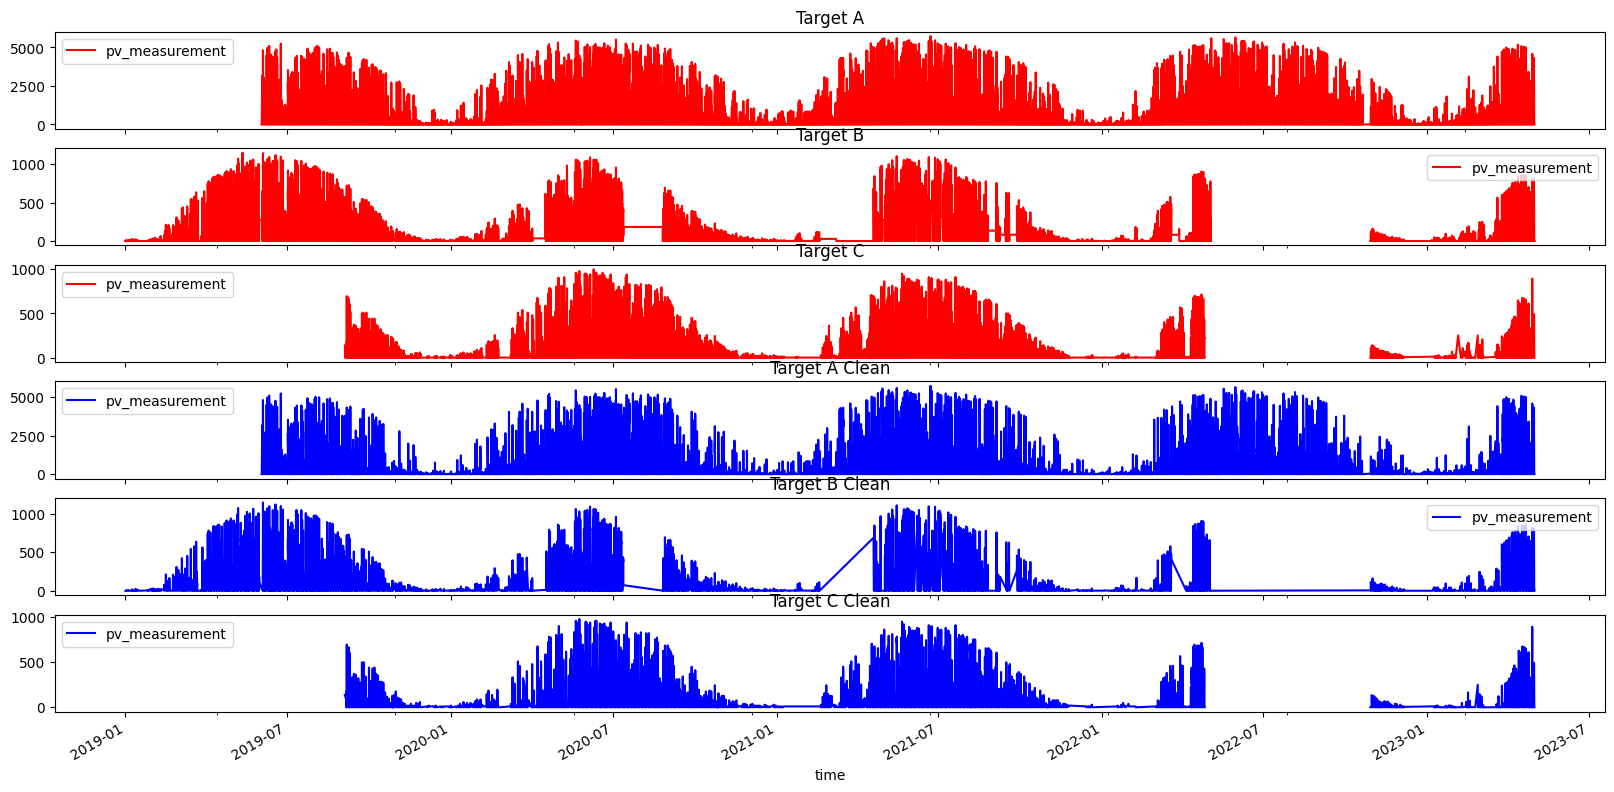

In [9]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
                zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [10]:
# Making sure that target values line up with x_values

def stocastic_median(x_list):
    s = np.median(x_list)
    return int(s)


def gen_agg(df: pd.DataFrame, agg_type, batch_size: int = 4, merge_on = 'first') -> pd.DataFrame:
    """
    Pass dataframe WITH date_forecast value and choose aggregation type by passing string to 'agg_type'
    """
    agg_func = {col: agg_type for col in df.columns[1:]} # [1:] assumes 'date_forecast' is first
    return df.groupby(df.index // batch_size).agg({**{'date_forecast': merge_on}, **agg_func})

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = gen_agg(categorical, agg_type=stocastic_median, merge_on = 'first')
   mean = gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train

X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [11]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  18071 18071
x,y:  12443 12443
x,y:  10129 10129


In [12]:
X_train[0].tail()


,date_forecast,dew_or_rime:idx,precip_type_5min:idx,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,estimation_calc_forecast_difference
18066,2023-04-30 19:00:00,0,0,0,1,4.55,1.27650,1674.199951,84464.945312,4.225,...,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0,1.0,44545.0
18067,2023-04-30 20:00:00,0,0,0,1,4.50,1.27975,1762.400024,2270.875000,0.000,...,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0,1.0,48145.0
18068,2023-04-30 21:00:00,0,0,0,1,4.50,1.28100,1696.650024,0.000000,0.000,...,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0,1.0,51745.0
18069,2023-04-30 22:00:00,0,0,0,1,4.50,1.28100,1353.400024,0.000000,0.000,...,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0,1.0,55345.0
18070,2023-04-30 23:00:00,0,0,0,1,4.50,1.28100,1626.574951,0.000000,0.000,...,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0,1.0,58945.0


# Feature engineering

### Timeseasonality

In [13]:
from typing import List

## We now need functions for assigning daily and YEARly cycles (described in datanalysis docu on Peter branch)
# plus 2 avoids 0 and negative values but we ignore this here since it allready normalises the data
DAY = 24*60*60
YEAR = (365.2425)*DAY
SHIFT = 0 #possible to shift oscilation to avoid 0 and or negative values.

# Conversion datetime -> unix_time
def get_unixtime(datetime: pd.Series) -> pd.Series:
    unixtime = (datetime - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    return unixtime

# functions for creating seasonality:
def sinus_day(unix_time):
    return SHIFT + np.sin(unix_time * (2 * np.pi / DAY)) # since it is seconds since 1.1.1970 we divide by seconds in a DAY to get seasonal changes throughout the dat

def sinus_year(unix_time):
    return SHIFT + np.sin(unix_time * (2 * np.pi / YEAR))

def cosinus_day(unix_time):
    return SHIFT + np.cos(unix_time * (2 * np.pi / DAY))

def cosinus_year(unix_time):
    return SHIFT + np.cos(unix_time * (2 * np.pi / YEAR))

# function for returning two series with the daily cycles (sine and cosine)
def get_daycycle(unixtime: pd.Series) -> List[pd.Series]:
    sinus_daytime = unixtime.apply(sinus_day)
    sinus_daytime = sinus_daytime.rename('sinus_day') 
    cosinus_daytime = unixtime.apply(cosinus_day)
    cosinus_daytime = cosinus_daytime.rename('cosinus_day')
    return [sinus_daytime, cosinus_daytime]

# Function for returning two series with the yearly cycles
def get_yearcycle(unixtime: pd.Series) -> List[pd.Series]:
    sinus_yeartime = unixtime.apply(sinus_year)
    sinus_yeartime = sinus_yeartime.rename('sinus_year')
    cosinus_yeartime = unixtime.apply(cosinus_year)
    cosinus_yeartime = cosinus_yeartime.rename('cosinus_year')
    return [sinus_yeartime, cosinus_yeartime]

def append_seasonal_columns(df: pd.DataFrame, time_column: str = 'date_forecast') -> pd.DataFrame:
    """
    returns joined Dataframe with seasonal data. Does not drop time_column
    """
    # check that time column exists
    if time_column not in df.columns: 
        raise Exception(f"The timecolumn passed: {time_column}, is not part of the dataset passed.")
    
    if not np.issubdtype(df[time_column], np.datetime64):
        raise Exception(f'Passed timecolumn must be of numpy datetime64. Passed type is {df[time_column].dtype()}')
    
    unixtime = get_unixtime(df[time_column])
    day_sin, day_cos = get_daycycle(unixtime)
    year_sin, year_cos = get_yearcycle(unixtime)
    df = df.join([day_sin, day_cos, year_sin, year_cos])
    
    return df


### One-Hot-Encoding

In [14]:

def one_hot_encode(df: pd.DataFrame, col_list: [str]):
  for col in col_list:
    column_to_encode = df[col]
    df_encoded = pd.get_dummies(column_to_encode, prefix=col) # Convert categorical variable into dummy/indicator variables
    df.drop(col, axis=1, inplace=True)
    df_encoded_binary = df_encoded.astype(int) # Convert to binary from boolean
    df = pd.concat([df, df_encoded_binary], axis=1) # Concatenate dataframes
  return df


### Date forecast columns

In [15]:
def date_forecast_columns(df: pd.DataFrame):

  date_forecast = df['date_forecast']
  
  df['year'] = date_forecast.dt.year
  df['month'] = date_forecast.dt.month
  df['day'] = date_forecast.dt.day
  df['hours'] = date_forecast.dt.hour
  df['day_of_week'] = date_forecast.dt.dayofweek
  df['day_of_year'] = date_forecast.dt.dayofyear
  df['week_of_year'] = date_forecast.dt.isocalendar().week

  return df


In [16]:
print(X_train[0].columns)


Index(['date_forecast', 'dew_or_rime:idx', 'precip_type_5min:idx',
       'is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [17]:

def more_features(df: pd.DataFrame) -> pd.DataFrame:
    # Convert the 'date_forecast' to datetime and set it as index
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    df.sort_index(inplace=True)
    print(df.head(10))
    # Now apply the rolling function
    df['max_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').max()
    df['min_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').min()
    df['total_solar_rad_1h'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
    df['total_wind_speed_10m'] = (df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)**0.5
    df['total_snow_1h'] = df[['fresh_snow_1h:cm', 'snow_melt_10min:mm']].sum(axis=1)
    df['pressure_variation_3h'] = df['sfc_pressure:hPa'].diff(periods=3)

    return df

for i in range(len(X_train)):
    X_train[i] = append_seasonal_columns(X_train[i])
    X_train[i] = date_forecast_columns(X_train[i])


for i in range(len(X_frames_test)):
    X_frames_test[i] = append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = date_forecast_columns(X_frames_test[i])  

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
    X_train[i] = one_hot_encode(X_train[i],OH_columns)
    X_frames_test[i] = one_hot_encode(X_frames_test[i], OH_columns)
    X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
    X_train[i] = more_features(X_train[i])
    X_frames_test[i] = more_features(X_frames_test[i])


                     is_day:idx  is_in_shadow:idx  absolute_humidity_2m:gm3  \
date_forecast                                                                 
2019-06-02 22:00:00           0                 1                     7.700   
2019-06-02 23:00:00           0                 1                     7.700   
2019-06-03 00:00:00           0                 1                     7.875   
2019-06-03 01:00:00           0                 1                     8.425   
2019-06-03 02:00:00           1                 0                     8.950   
2019-06-03 03:00:00           1                 0                     9.250   
2019-06-03 04:00:00           1                 0                     9.525   
2019-06-03 05:00:00           1                 0                     9.700   
2019-06-03 06:00:00           1                 0                     9.550   
2019-06-03 07:00:00           1                 0                     9.450   

                     air_density_2m:kgm3  ceiling_h

# Data cleaning

In [18]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,3525,2104,2289
cloud_base_agl:m,1322,910,873
snow_density:kgm3,17719,12166,10116
pressure_variation_3h,3,3,3


In [19]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
pressure_variation_3h,3,3,3


In [20]:
print(X_train[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'estimate

In [21]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
X_train[0].describe().transpose()

# top_10_worst_features = ['precip_type_5min:idx_5', 'wind_speed_w_1000hPa:ms', 'dew_or_rime:idx_-1', 'precip_type_5min:idx_2', 'dew_or_rime:idx_1', 'snow_drift:idx', 'dew_or_rime:idx_0', 'prob_rime:p', 'precip_type_5min:idx_3', 'fresh_snow_1h:cm',
#                          'fresh_snow_3h:cm', 'snow_melt_10min:mm', 'fresh_snow_6h:cm', 'snow_depth:cm', 'precip_type_5min:idx_1',
#                          'rain_water:kgm2', 'fresh_snow_12h:cm']
# top_5_worst_features = ['snow_drift:idx', 'dew_or_rime:idx_-1', 'dew_or_rime:idx_0', 'precip_type_5min:idx_5', 'precip_type_5min:idx_2', 
#                         'wind_speed_u_10m:ms', 'wind_speed_w_1000hPa:ms','wind_speed_v_10m:ms'
#                         ]
# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_5_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_5_worst_features, inplace=True)

# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_10_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_10_worst_features, inplace=True)


# for i in range(len(X_train)):
#     X_train[i]['diffuse_rad:W_mean_prev_hour'] = X_train[i]['diffuse_rad:W_mean'].shift(1)
#     X_train[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_train[i]['diffuse_rad_1h:J_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad:W_mean_prev_hour'] = X_frames_test[i]['diffuse_rad:W_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_frames_test[i]['diffuse_rad_1h:J_mean'].shift(1)




,count,mean,std,min,25%,50%,75%,max
is_day:idx,18071.0,0.634442,0.4816,0.0,0.0,1.0,1.0,1.0
is_in_shadow:idx,18071.0,0.376736,0.484581,0.0,0.0,0.0,1.0,1.0
absolute_humidity_2m:gm3,18071.0,7.061308,2.840138,0.9,4.75,7.025,9.0,17.35
air_density_2m:kgm3,18071.0,1.243987,0.035809,1.145,1.21975,1.241,1.2675,1.40525
ceiling_height_agl:m,14546.0,3167.110107,2689.152344,28.0,1174.868774,2090.075195,4559.837402,12005.599609
...,...,...,...,...,...,...,...,...
total_snow_1h,18071.0,0.005153,0.078004,0.0,0.0,0.0,0.0,3.55
pressure_variation_3h,18068.0,0.001479,3.578179,-35.200073,-0.850037,0.0,0.849976,40.150024
msl_pressure:hPa_mean,18071.0,1006.070496,11.872775,941.887512,998.868713,1007.099976,1013.949951,1038.943726
diffuse_rad:W_mean,18071.0,66.710594,90.095024,0.0,0.0,20.275,108.881248,386.637512


In [22]:
print(X_frames_test[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'estimate

In [23]:
X_train_ag = [X_train[0].__deepcopy__(), X_train[1].__deepcopy__(), X_train[2].__deepcopy__()]
X_frames_test_ag = [X_frames_test[0].__deepcopy__(), X_frames_test[1].__deepcopy__(), X_frames_test[2].__deepcopy__()]


In [24]:
def multiply_columns(A: pd.Series, B: pd.Series) -> pd.Series:
    '''
    Given two pandas series, returns a series with multiplied values. 

    NB! Series A and B must be of same length
    '''

    if len(A) != len(B): 
        raise Exception("In multiply columns -> length of series is not equal")
    
    C = A*B

    return C


In [25]:
## Multiplying effective cloud coverage with clear sky radiation

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train_ag)):
    A = X_train_ag[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train_ag[i]['clear_sky_rad:W']
    AT = X_frames_test_ag[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test_ag[i]['clear_sky_rad:W']

    X_train_ag[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test_ag[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] =  multiply_columns(AT, BT)
    X_train_ag[i].drop(columns=['clear_sky_rad:W', 'clear_sky_energy_1h:J'])


In [26]:
from math import sin, radians

def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train_ag)):
    A = X_train_ag[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train_ag[i]['air_density_2m:kgm3']
    AT = X_frames_test_ag[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test_ag[i]['air_density_2m:kgm3']

    X_train_ag[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test_ag[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)
    X_train_ag[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    X_frames_test_ag[i].drop(columns=['air_density_2m:kgm3'], inplace=True)


In [27]:
def flip_ceiling_height(x):
    flip_val = 12005.7
    null_dist = 1000
    return abs(x-(flip_val+null_dist))

for i in range(len(X_train_ag)):
    X_frames_test_ag[i]['ceiling_height_agl:m'] = X_frames_test_ag[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)
    X_train_ag[i]['ceiling_height_agl:m']= X_train_ag[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)


In [28]:
def flip_cloud_base(x):
    flip_val = 11467.8
    null_dist = 1000
    return abs(x-(flip_val+null_dist))
for i in range(len(X_train_ag)):
    X_frames_test_ag[i]['cloud_base_agl:m'] = X_frames_test_ag[i]['cloud_base_agl:m'].apply(flip_ceiling_height)
    X_train_ag[i]['cloud_base_agl:m']= X_train_ag[i]['cloud_base_agl:m'].apply(flip_ceiling_height)


In [29]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 0, "cloud_base_agl:m": 0}

for i in range(len(X_train_ag)):
    X_train_ag[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test_ag[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train_ag[i].fillna(value=values, inplace=True)
    X_frames_test_ag[i].fillna(value=values, inplace=True)
    X_frames_test_ag[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [30]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [31]:
print(X_train_ag[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'msl_pressure:hPa', 'precip_5min:mm', 'pressure_100m:hPa',
       'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_difference', 'sinus_day', 'co

# Training the model

### Catboost

In [32]:



# Use params from hyperparameter tuning using optuna
params_a = {'random_state': 42, 'learning_rate': 0.039975576144155645, 'depth': 9, 'subsample': 0.4504678933801176, 'colsample_bylevel': 0.9773225861097778, 'min_data_in_leaf': 90}
params_b = {'random_state': 42, 'learning_rate': 0.023765834908014156, 'depth': 10, 'subsample': 0.8298593330195755, 'colsample_bylevel': 0.6060393047650714, 'min_data_in_leaf': 61}
params_c = {'random_state': 42, 'learning_rate': 0.060183973978509046, 'depth': 10, 'subsample': 0.28819995411353627, 'colsample_bylevel': 0.39818319507473743, 'min_data_in_leaf': 77}

model_a = CatBoostRegressor(**params_a)
model_b = CatBoostRegressor(**params_b)
model_c = CatBoostRegressor(**params_c)


model_a.fit(X_train[0], Y_train[0])
model_b.fit(X_train[1], Y_train[1])
model_c.fit(X_train[2], Y_train[2])


0:	learn: 1281.7710412	total: 76.2ms	remaining: 1m 16s
1:	learn: 1241.7145470	total: 90.8ms	remaining: 45.3s
2:	learn: 1204.1376570	total: 107ms	remaining: 35.6s
3:	learn: 1167.3686368	total: 125ms	remaining: 31.2s
4:	learn: 1132.5205933	total: 137ms	remaining: 27.3s
5:	learn: 1099.2098086	total: 151ms	remaining: 25s
6:	learn: 1067.3930553	total: 169ms	remaining: 24s
7:	learn: 1037.9648835	total: 182ms	remaining: 22.5s
8:	learn: 1009.4486590	total: 194ms	remaining: 21.4s
9:	learn: 982.5353865	total: 212ms	remaining: 21s
10:	learn: 956.2615837	total: 224ms	remaining: 20.1s
11:	learn: 931.3727707	total: 239ms	remaining: 19.7s
12:	learn: 907.7454233	total: 253ms	remaining: 19.2s
13:	learn: 885.0786608	total: 265ms	remaining: 18.7s
14:	learn: 863.6154825	total: 282ms	remaining: 18.5s
15:	learn: 843.2606308	total: 296ms	remaining: 18.2s
16:	learn: 823.6618699	total: 307ms	remaining: 17.8s
17:	learn: 805.5933172	total: 324ms	remaining: 17.7s
18:	learn: 788.7651175	total: 338ms	remaining: 17.

In [33]:
print(Y_train[0].head())


0     0.00
1     0.00
2     0.00
3     0.00
4    19.36
Name: pv_measurement, dtype: float64


### AutoGluon

In [34]:
X_train_ag[0].columns


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'msl_pressure:hPa', 'precip_5min:mm', 'pressure_100m:hPa',
       'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_difference', 'sinus_day', 'co

In [35]:
def combine_all_frames(frames: [pd.DataFrame]):
    
    for i, frame in enumerate(frames):
        if i == 0:
            frame['location'] = '0'
        elif i == 1:
            frame['location'] = '1'
        elif i == 2:
            frame['location'] = '2'
    combined = pd.concat(frames)
    combined = combined.reset_index(drop=True)
    combined['location'] = combined['location'].astype('float64')

    return combined

def combine_series(series: [pd.Series]) -> pd.Series:
    combined = pd.concat(series)
    combined.reset_index(drop=True, inplace=True)
    return combined


In [36]:
print(Y_train[0].head(10))

for i in range(len(X_train_ag)):
    X_train_ag[i].reset_index(drop=True, inplace=True)
    
X_comb = combine_all_frames(X_train_ag)
NYA=(Y_train[0]-Y_train[0].mean())/Y_train[0].std()
NYB=(Y_train[1]-Y_train[1].mean())/Y_train[1].std()
NYC=(Y_train[2]-Y_train[2].mean())/Y_train[2].std()
Y_comb = combine_series([NYA, NYB, NYC])
Y_comb.reset_index(drop=True, inplace=True)
print(X_train_ag[0].columns)


0       0.00
1       0.00
2       0.00
3       0.00
4      19.36
5     251.02
6     263.78
7     522.72
8     904.42
9    1238.82
Name: pv_measurement, dtype: float64
Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'msl_pressure:hPa', 'precip_5min:mm', 'pressure_100m:hPa',
       'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_spe

In [37]:
from autogluon.tabular import TabularDataset, TabularPredictor



joined = pd.merge(X_comb, Y_comb, left_index=True, right_index=True)
train = TabularDataset(joined)
predictor = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train, presets='medium_quality') #, presets='good_quality', time_limit=3600)


/Users/hansstem/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels/ag-20231112_115600/"
Presets specified: ['medium_quality']
Cannot interpret 'UInt32Dtype()' as a data type
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231112_115600/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Oct  4 21:26:43 PDT 2023; root:xnu-8796.141.3.701.17~4/RELEASE_ARM64_T8112
Disk Space Avail:   331.39 GB / 494.38 GB (67.0%)
Train Data Rows:    40643
Train Data Columns: 72
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column

[1000]	valid_set's l1: 0.145768
[2000]	valid_set's l1: 0.134557
[3000]	valid_set's l1: 0.128937
[4000]	valid_set's l1: 0.125034
[5000]	valid_set's l1: 0.122006
[6000]	valid_set's l1: 0.119717
[7000]	valid_set's l1: 0.118077
[8000]	valid_set's l1: 0.116557
[9000]	valid_set's l1: 0.115397
[10000]	valid_set's l1: 0.114545


	-0.1145	 = Validation score   (-mean_absolute_error)
	43.78s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l1: 0.13429
[2000]	valid_set's l1: 0.124268
[3000]	valid_set's l1: 0.119933
[4000]	valid_set's l1: 0.117179
[5000]	valid_set's l1: 0.1154
[6000]	valid_set's l1: 0.114247
[7000]	valid_set's l1: 0.113477
[8000]	valid_set's l1: 0.113037
[9000]	valid_set's l1: 0.11265
[10000]	valid_set's l1: 0.112341


	-0.1123	 = Validation score   (-mean_absolute_error)
	43.61s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.1466	 = Validation score   (-mean_absolute_error)
	47.22s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1246	 = Validation score   (-mean_absolute_error)
	81.73s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.1427	 = Validation score   (-mean_absolute_error)
	9.11s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1561	 = Validation score   (-mean_absolute_error)
	16.33s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1191	 = Validation score   (-mean_absolute_error)
	48.36s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.1768	 = Validation score   (-mean_absolute_error)
	14.97s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: Lig

[1000]	valid_set's l1: 0.117596
[2000]	valid_set's l1: 0.111747
[3000]	valid_set's l1: 0.109749
[4000]	valid_set's l1: 0.108943
[5000]	valid_set's l1: 0.108603
[6000]	valid_set's l1: 0.108378
[7000]	valid_set's l1: 0.108268
[8000]	valid_set's l1: 0.108197
[9000]	valid_set's l1: 0.108158
[10000]	valid_set's l1: 0.108137


	-0.1081	 = Validation score   (-mean_absolute_error)
	159.58s	 = Training   runtime
	0.69s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1072	 = Validation score   (-mean_absolute_error)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 469.57s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231112_115600/")


# Evaluate prediction

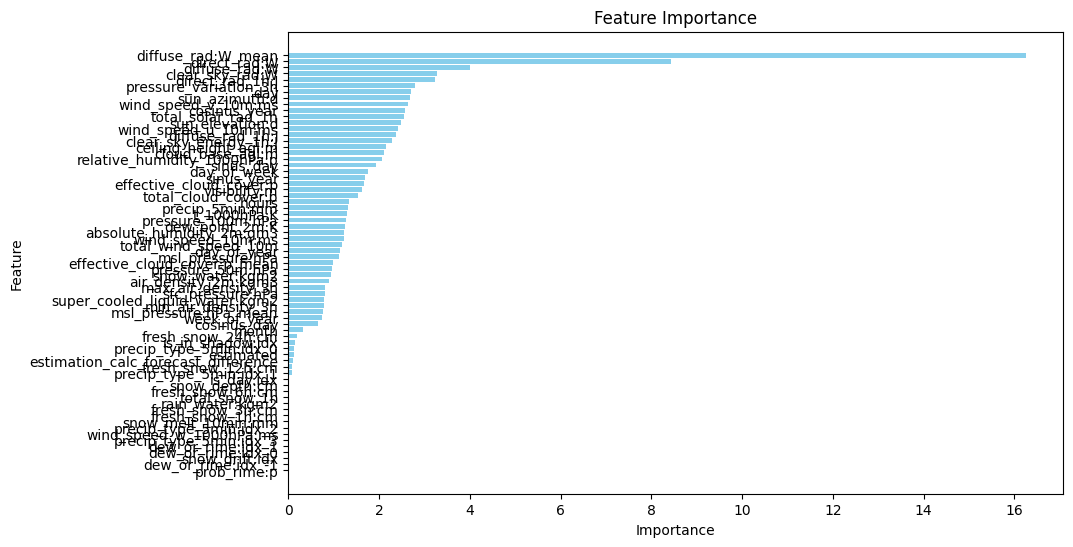

In [38]:
# Feature importance catboost

import matplotlib.pyplot as plt

feature_importance = model_a.get_feature_importance()
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': X_train[0].columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()


In [39]:
# Feature importance autogluon

# import matplotlib.pyplot as plt

# feature_importance = predictor.feature_importance()

# # Create a DataFrame to store feature names and their importance scores
# importance_df = pd.DataFrame({'Feature': X_train_ag[0].columns, 'Importance': feature_importance})

# # Sort the DataFrame by importance scores in descending order
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Create a bar plot to visualize feature importance

# plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
# plt.show()


# Make predictions

In [40]:
def upscale(val, location: int):
    return (val * Y_train[location].std())+Y_train[location].mean()


In [41]:
# Train the model on the entire training data

y_pred_cat_a = model_a.predict(X_frames_test[0]) * X_frames_test[0]['is_day:idx']
y_pred_cat_b = model_b.predict(X_frames_test[1]) * X_frames_test[1]['is_day:idx']
y_pred_cat_c = model_c.predict(X_frames_test[2]) * X_frames_test[2]['is_day:idx']

x_test_comb = combine_all_frames(X_frames_test_ag)
x_test_comb['index'] = range(len(x_test_comb))
pred_test = predictor.predict(x_test_comb)

a_ind_test = x_test_comb[x_test_comb['location'] == 0].index
b_ind_test = x_test_comb[x_test_comb['location'] == 1].index
c_ind_test = x_test_comb[x_test_comb['location'] == 2].index

y_pred_ag_a = upscale(pred_test[a_ind_test], 0)#* X_frames_test_ag[0]['is_day:idx']
y_pred_ag_b = upscale(pred_test[b_ind_test], 1)#* X_frames_test_ag[1]['is_day:idx']
y_pred_ag_c = upscale(pred_test[c_ind_test], 2)#* X_frames_test_ag[2]['is_day:idx']

y_pred_cat = np.concatenate((y_pred_cat_a, y_pred_cat_b, y_pred_cat_c), axis=0)
y_pred_ag = np.concatenate((y_pred_ag_a, y_pred_ag_b, y_pred_ag_c), axis=0)


In [42]:
len(y_pred_ag_a)


720

### Combine predictions

In [43]:

mean_of_predictions = (y_pred_cat + y_pred_ag) / 2
y_pred = mean_of_predictions


In [44]:
print(len(y_pred_cat))
print(len(y_pred_ag))


2160
2160


In [45]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0
    if i < 720:
        if y_pred_cat[i] < 20: 
            y_pred_cat[i] = 0
    else:
        if y_pred_cat[i] < 10: 
            y_pred_cat[i] = 0

    if i < 720:
        if y_pred_ag[i] < 20: 
            y_pred_ag[i] = 0
    else:
        if y_pred_ag[i] < 10: 
            y_pred_ag[i] = 0



# Create submission

In [46]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_SH1_m_cat_ag_r_hans_bug.csv', index=False)


In [47]:
y_test_pred = y_pred_cat

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_SH1_m_cat_r_hans_bug.csv', index=False)


In [48]:
y_test_pred = y_pred_ag

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_SH1_m_ag_r_hans_bug.csv', index=False)


(2160,)
(2160,)


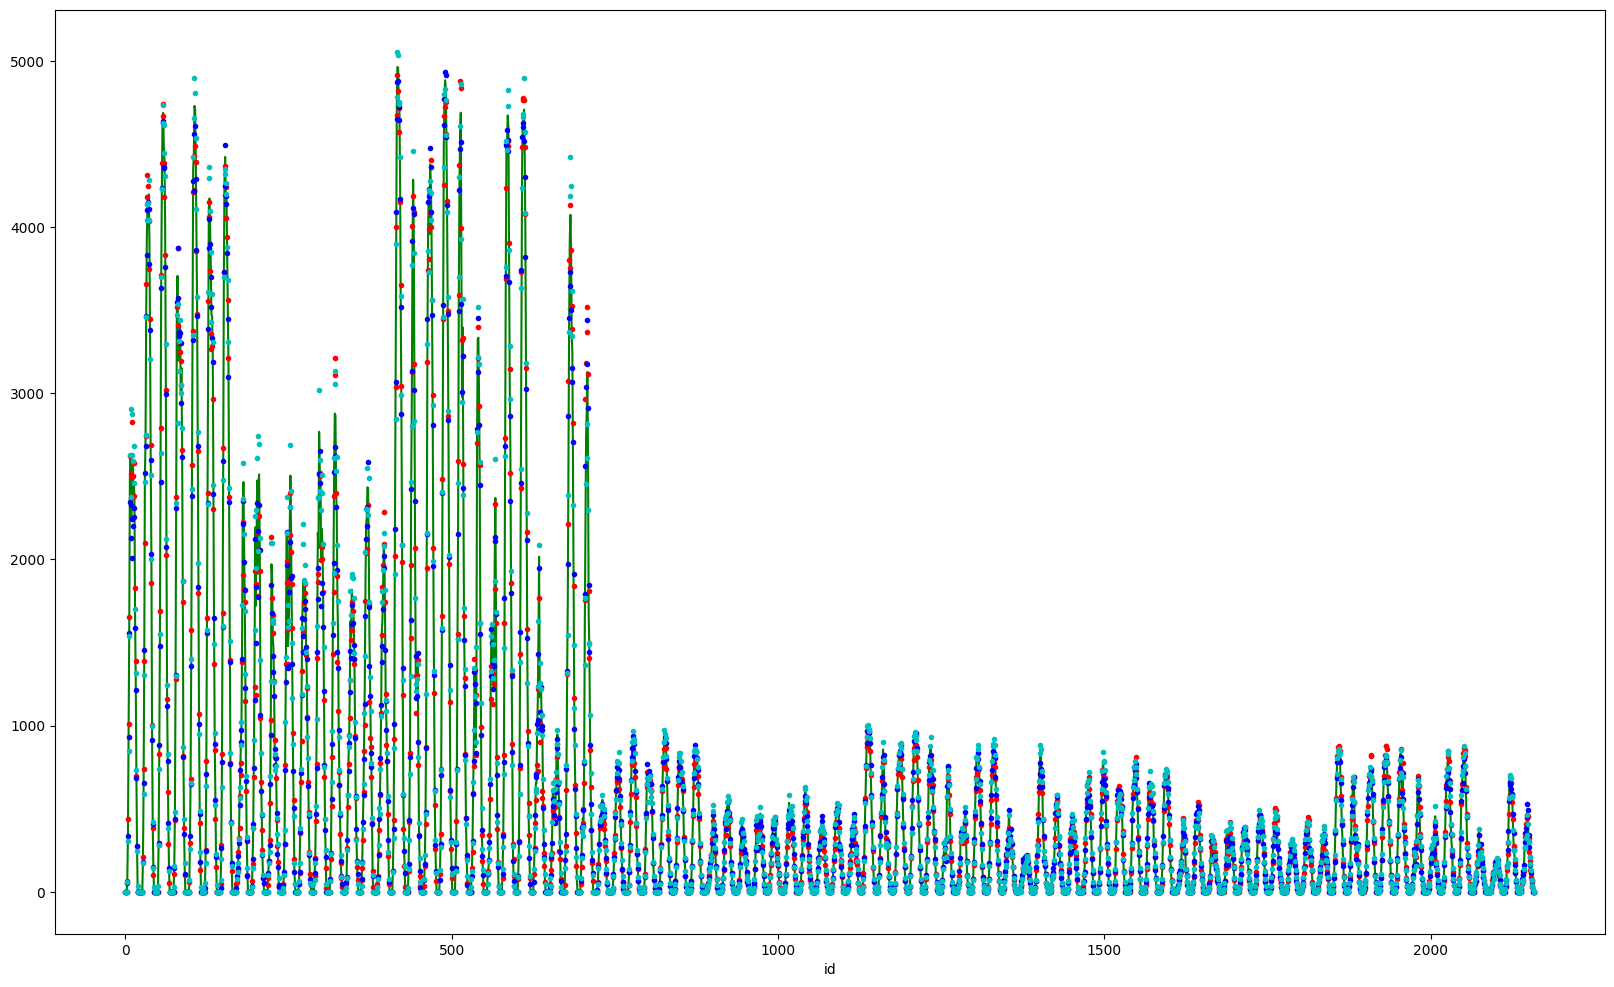

In [55]:
best_submission = pd.read_csv('../model_notebooks/submissions/submission_cat.csv')
second_best_sub = pd.read_csv('./submissions/submission_SH1_m_cat_ag_r_hans_bug.csv')
ag = pd.read_csv('./submissions/submission_SH1_m_ag_r_hans_bug.csv')
ag_1 = pd.read_csv('./submissions/submission_SH1_m_ag.csv')
cat = pd.read_csv('./submissions/submission_SH1_m_cat_r_hans_bug.csv')
cat_2 = pd.read_csv('./submissions/submission_SH1_cat_2.csv')

print(y_pred.shape)
print(best_submission['prediction'].shape)
plt.figure(figsize=(20,12))

plt.plot(second_best_sub['prediction'], 'g')
plt.plot(best_submission['prediction'], 'r.')
plt.plot(cat['prediction'], 'b.')
plt.plot(ag['prediction'], 'c.')
plt.xlabel("id")
plt.show()


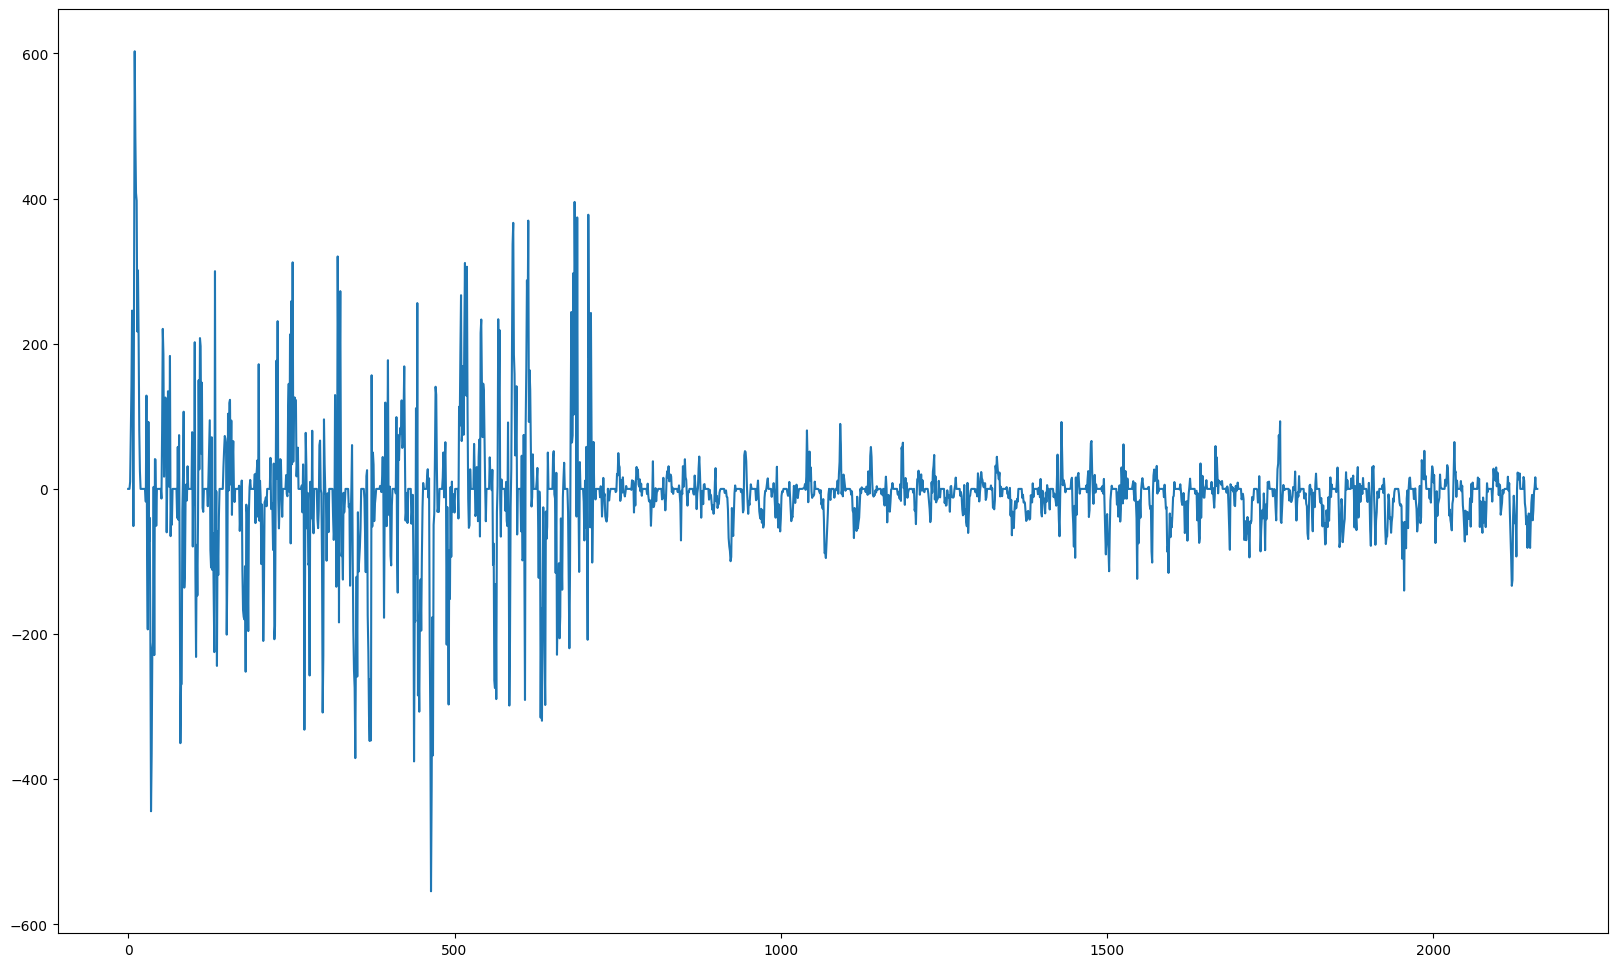

In [56]:
diff_cat = cat_2['prediction']-cat['prediction']
plt.figure(figsize=(20,12))
plt.plot(diff_cat)


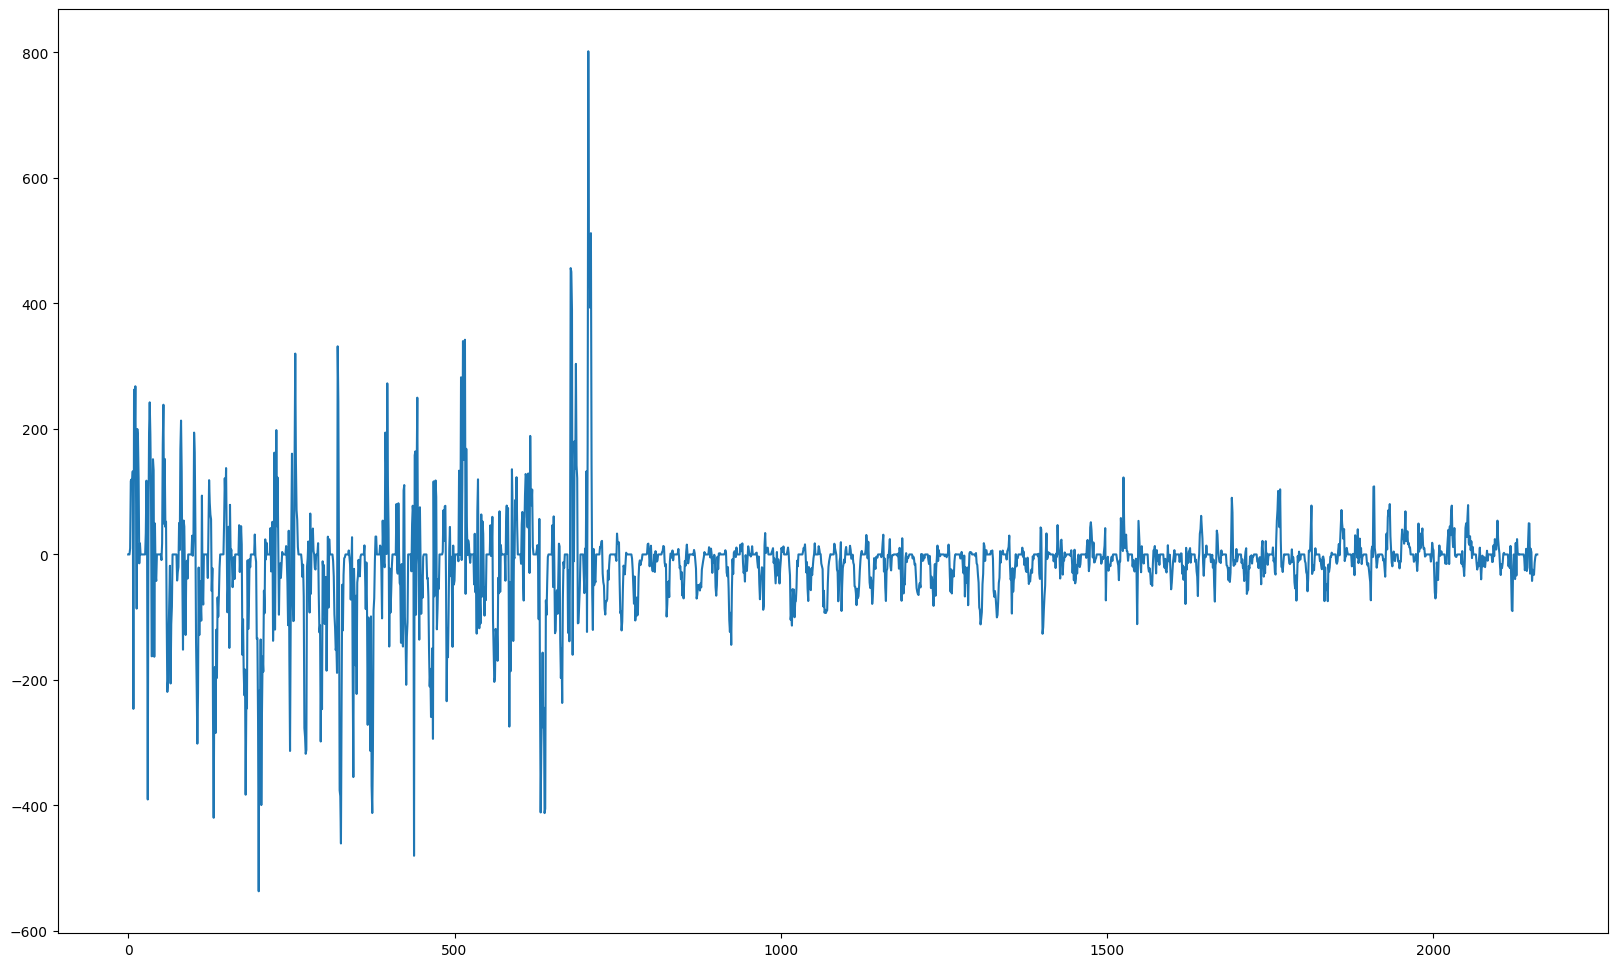

In [57]:
dist = best_submission['prediction'] - second_best_sub['prediction']

plt.figure(figsize=(20,12))
plt.plot(dist)


In [58]:
abs(dist).mean()


40.0144997478143

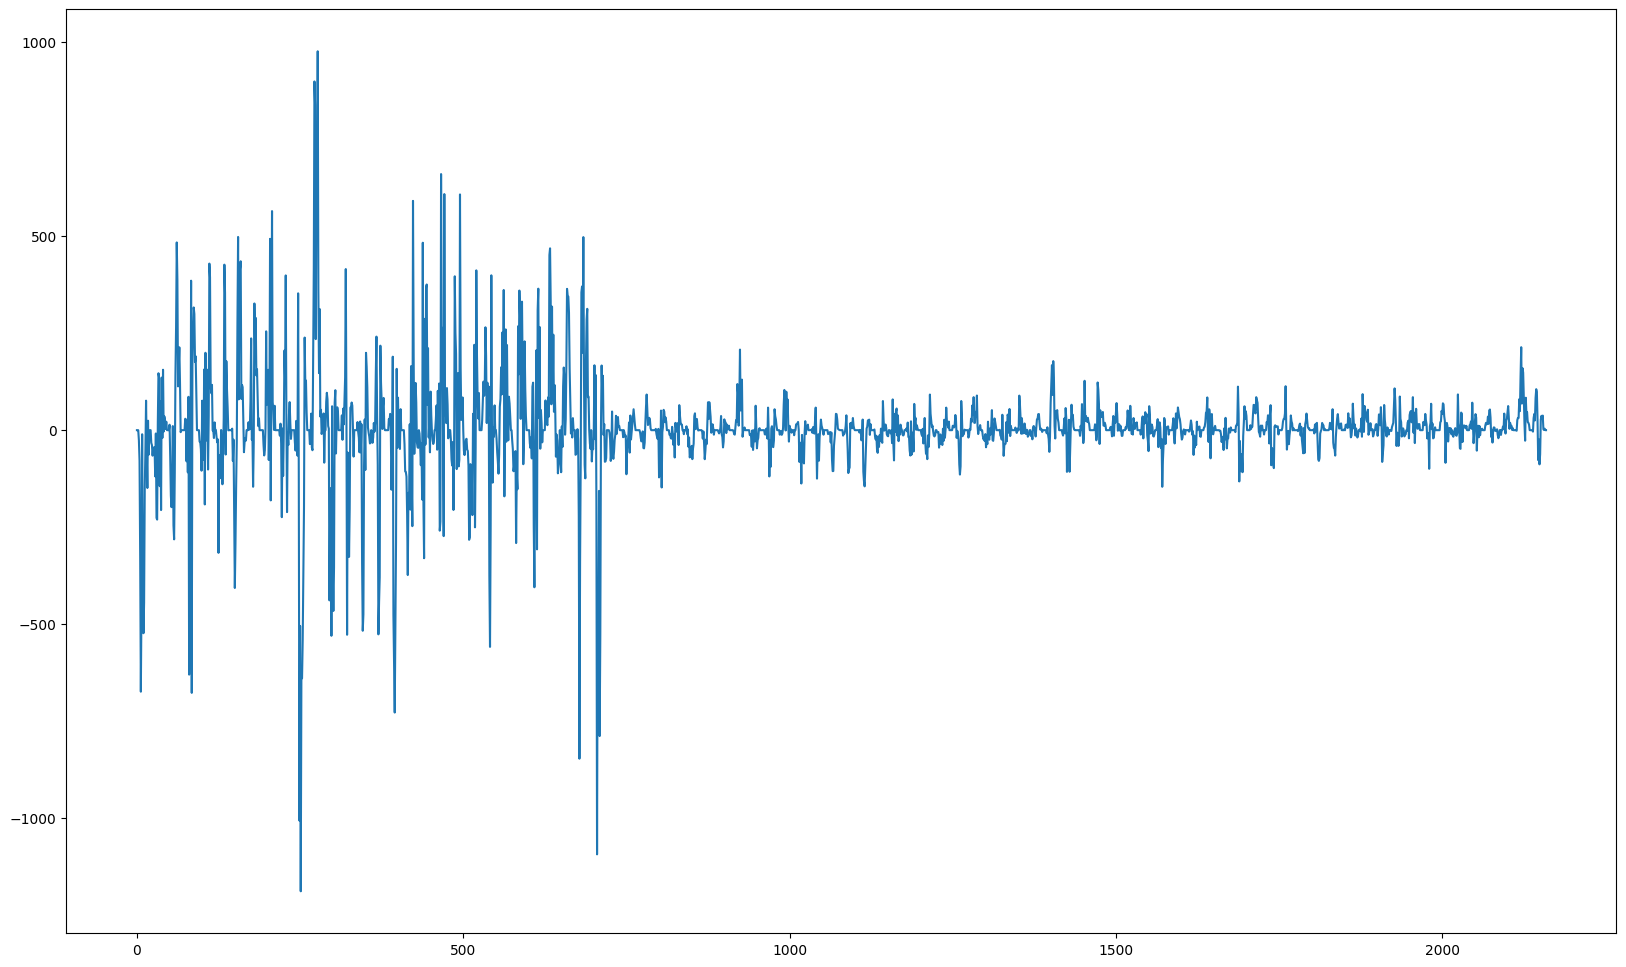

In [59]:
diff_ag = ag['prediction'] - ag_1['prediction']
plt.figure(figsize=(20,12))
plt.plot(diff_ag)
